In [1]:
import pandas as pd
import numpy as np
import glob
import re
import types
import multiprocessing
import sys 
sys.path.append("../")
from multiprocessing import Pool
import matplotlib.pyplot as plt
from scipy import interpolate

# io_f, compute_fはコンペのgithubから持ってきたファイル
from src.io_f import read_data_file
import src.compute_f as compute_f


In [2]:
def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val
        # functions / callables
        if hasattr(val, '__call__'):
            yield name, val
np.seterr(divide='ignore', invalid='ignore')
noglobal = lambda fn: types.FunctionType(fn.__code__, dict(imports()))

In [3]:
# 加速度と磁場？から相対位置を算出
# https://www.kaggle.com/saitodevel01/indoor-post-processing-by-cost-minimization
def compute_rel_positions(acce_datas, ahrs_datas):
    """
    input: (2316, 4) (timestamp, x, y, z)
    output: 
    """
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions


def correct_path(args):
    path, path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    
    example = read_data_file(f'{INPUT_PATH}/test/{path}.txt')
    rel_positions = compute_rel_positions(example.acce, example.ahrs)
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

In [4]:
# testで予測するサイトを見てみる
sample_submission = pd.read_csv(f'../input/indoor-location-navigation/sample_submission.csv')
sitename = sample_submission['site_path_timestamp'].str.split('_', expand=True)[0].unique()
sitename

array(['5a0546857ecc773753327266', '5c3c44b80379370013e0fd2b',
       '5d27075f03f801723c2e360f', '5d27096c03f801723c31e5e0',
       '5d27097f03f801723c320d97', '5d27099f03f801723c32511d',
       '5d2709a003f801723c3251bf', '5d2709b303f801723c327472',
       '5d2709bb03f801723c32852c', '5d2709c303f801723c3299ee',
       '5d2709d403f801723c32bd39', '5d2709e003f801723c32d896',
       '5da138274db8ce0c98bbd3d2', '5da1382d4db8ce0c98bbe92e',
       '5da138314db8ce0c98bbf3a0', '5da138364db8ce0c98bc00f1',
       '5da1383b4db8ce0c98bc11ab', '5da138754db8ce0c98bca82f',
       '5da138764db8ce0c98bcaa46', '5da1389e4db8ce0c98bd0547',
       '5da138b74db8ce0c98bd4774', '5da958dd46f8266d0737457b',
       '5dbc1d84c1eb61796cf7c010', '5dc8cea7659e181adb076a3f'],
      dtype=object)

## サンプルを取得

In [11]:
%%time 
# 予測対象のサイトのサンプルを取得する
# path_file = '../input/indoor-location-navigation/train/5a0546857ecc773753327266/F1/5e15a2cd1506f2000638fd6a.txt'
# path_file = '../input/indoor-location-navigation/train/5c3c44b80379370013e0fd2b/F3/5d08a56a3f461f0008dac61a.txt'
path_file = '../input/indoor-location-navigation/train/5dbc1d84c1eb61796cf7c010/F2/5dd36c9d44333f00067aa165.txt'
example = read_data_file(path_file)
trajectory = example.waypoint
wifi = example.wifi
sensor = compute_rel_positions(example.acce, example.ahrs)

trajectory_timestamp = trajectory[:,0]
trajectory_waypoint = trajectory[:, 1:]
wifi_timestamp = np.unique(wifi[:, 0]).astype(int)

CPU times: user 149 ms, sys: 19.5 ms, total: 169 ms
Wall time: 168 ms


現状は  
trajectoryのtimestampとwaypoint  
wifiのtimestamp  
  
がわかっている状態  
ここからwifiのwaypointを求めたい

## センサデータから相対位置を取得しwifiデータのwaypointを取得

In [6]:
# センサデータのtimestampとwaypointを取得
@noglobal
def complement_sensor_waypoint(trajectory_timestamp, trajectory_waypoint, sensor):
    sensor_timestamp = sensor[:, 0]
    sensor_rel_waypoint = sensor[:, 1:]
    sensor_waypoint = []
    for i in range(len(trajectory_timestamp)-1):
        # あるwaypointから次のwaypointの間にあるsensorデータを取り出したいのでtimestampで該当のidxを取得
        target_idx = (sensor_timestamp > trajectory_timestamp[i]) & (sensor_timestamp < trajectory_timestamp[i+1])
        # 対象区間の相対位置の累積和を取りスタート地点のwaypointを足すことでsensorによる位置が取得できる
        tmp_sensor_waypoint = trajectory_waypoint[i] + np.cumsum(sensor_rel_waypoint[target_idx], axis=0)
        sensor_waypoint.append(tmp_sensor_waypoint)
    sensor_waypoint = np.concatenate(sensor_waypoint)
    return sensor_timestamp, sensor_waypoint

In [7]:
%%time
sensor_timestamp, sensor_waypoint = complement_sensor_waypoint(trajectory_timestamp, trajectory_waypoint, sensor)

CPU times: user 617 µs, sys: 134 µs, total: 751 µs
Wall time: 607 µs


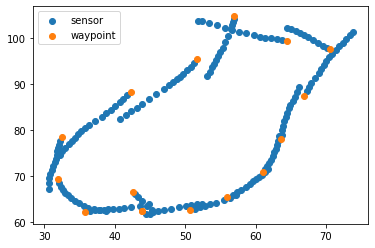

In [88]:
# センサデータによるwaypointを可視化
x_sensor = sensor_waypoint[:,0]
y_sensor = sensor_waypoint[:,1]
x_observed = trajectory_waypoint[:,0]
y_observed = trajectory_waypoint[:,1]
plt.scatter(x_sensor, y_sensor, label='sensor')
plt.scatter(x_observed, y_observed, label='waypoint')
plt.legend()

In [8]:
# wifiのtimestampに最も近いものをsensor_timestampから取得しそれに対応するwaypointをwifiのwaypointとして取得
def complement_wifi_waypoint(wifi_timestamp, sensor_timestamp, sensor_waypoint):
    x_sensor = sensor_waypoint[:,0]
    y_sensor = sensor_waypoint[:,1]
    wifi_x_by_sensor = []
    wifi_y_by_sensor = []
    wifi_timestamp_by_sensor = []
    for i in wifi_timestamp:
        idx = np.abs(sensor_timestamp - i).argmin()  # wifiデータとtimestampが最も近いものをsensor_timestampから取得
        wifi_timestamp_by_sensor.append(sensor_timestamp[idx])
        wifi_x_by_sensor.append(x_sensor[idx])
        wifi_y_by_sensor.append(y_sensor[idx])

    wifi_waypoint_by_sensor = np.stack([wifi_x_by_sensor, wifi_y_by_sensor], axis=1)
    return wifi_waypoint_by_sensor

In [9]:
%%time
wifi_waypoint = complement_wifi_waypoint(wifi_timestamp, sensor_timestamp, sensor_waypoint)

CPU times: user 567 µs, sys: 123 µs, total: 690 µs
Wall time: 464 µs


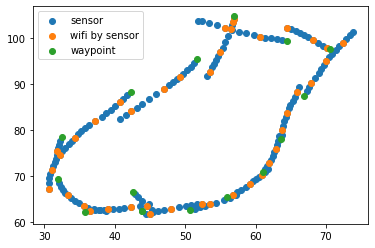

In [91]:
# センサデータによるwaypointを可視化
x_wifi = wifi_waypoint[:,0]
y_wifi = wifi_waypoint[:,1]
x_observed = trajectory_waypoint[:,0]
y_observed = trajectory_waypoint[:,1]
plt.scatter(x_sensor, y_sensor, label='sensor')
plt.scatter(x_wifi,y_wifi, label='wifi by sensor')
plt.scatter(x_observed,y_observed, label='waypoint')
plt.legend()

地図での可視化もやってみる。

In [92]:
# githubで与えられている関数を一部変更して利用
import plotly.graph_objs as go
from PIL import Image
import plotly
@noglobal
def visualize_trajectory(
    trajectory_waypoint, trajectory_timestamp,  # 元から与えられているwaypointの情報
    wifi_waypoint, wifi_timestamp,   # 上で算出したwifiの情報
    sensor_waypoint, sensor_timestamp,  # 上で算出したsensorの情報
    floor_plan_filename, width_meter, height_meter, title=None, show=False):
    fig = go.Figure()

    # waypoint
    size_list = [10] * trajectory_waypoint.shape[0]
    color_list = ['rgba(235, 5, 5, 1)'] * trajectory_waypoint.shape[0]

    text_list = trajectory_timestamp       
    text_list[0] = f'Start Point: {str(text_list[0])}'
    text_list[-1] = f'End Point: {str(text_list[-1])}'

    fig.add_trace(
        go.Scattergl(
            x=trajectory_waypoint[:, 0],
            y=trajectory_waypoint[:, 1],
            mode='lines + markers + text',
            marker=dict(size=size_list, color=color_list),
            line=dict(shape='linear', color='rgba(235, 5, 5, 1)', width=2, dash='dot'),
            text=text_list,
            textposition="top center",
            name='trajectory',
        ))

    # wifi
    size_list = [7] * wifi_waypoint.shape[0]
    color_list = ['rgba(4, 174, 4, 0.5)'] * wifi_waypoint.shape[0]
    text_list = wifi_timestamp       

    fig.add_trace(
        go.Scattergl(
            x=wifi_waypoint[:, 0],
            y=wifi_waypoint[:, 1],
            mode='lines + markers + text',
            marker=dict(size=size_list, color=color_list),
            line=dict(shape='linear', color='rgba(4, 174, 4, 0.5)', width=2, dash='dot'),
            text=text_list,
            textposition="top center",
            name='wifi',
        ))

    # sensor
    size_list = [7] * sensor_waypoint.shape[0]
    color_list = ['rgba(12, 5, 235, 1)'] * sensor_waypoint.shape[0]
    text_list = sensor_timestamp       

    fig.add_trace(
        go.Scattergl(
            x=sensor_waypoint[:, 0],
            y=sensor_waypoint[:, 1],
            mode='markers + text',
            marker=dict(size=size_list, color=color_list),
            line=dict(shape='linear', color='rgba(12, 5, 235, 1)', width=2, dash='dot'),
            text=text_list,
            textposition="top center",
            name='sensor',
        ))

    # add floor plan
    floor_plan = Image.open(floor_plan_filename)
    fig.update_layout(images=[
        go.layout.Image(
            source=floor_plan,
            xref="x",
            yref="y",
            x=0,
            y=height_meter,
            sizex=width_meter,
            sizey=height_meter,
            sizing="contain",
            opacity=1,
            layer="below",
        )
    ])

    # configure
    fig.update_xaxes(autorange=False, range=[0, width_meter])
    fig.update_yaxes(autorange=False, range=[0, height_meter], scaleanchor="x", scaleratio=1)
    fig.update_layout(
        title=go.layout.Title(
            text=title or "No title.",
            xref="paper",
            x=0,
        ),
        autosize=True,
        width=900,
        height=200 + 900 * height_meter / width_meter,
        template="plotly_white",
    )

    if show:
        fig.show()

    return fig   

In [93]:
# jsonデータとpngデータを取得
import json
site = path_file.split('/')[4]
floor = path_file.split('/')[-2]
floor_plan_filename = f'../input/indoor-location-navigation/metadata/{site}/{floor}/floor_image.png'
json_plan_filename = f'../input/indoor-location-navigation/metadata/{site}/{floor}/floor_info.json'

with open(json_plan_filename) as json_file:
    json_data = json.load(json_file)
    
width_meter = json_data["map_info"]["width"]
height_meter = json_data["map_info"]["height"]

# Title
title = "Example of Waypoint"

In [95]:
# 地図中にtimestampを可視化させたいので文字列にする
# 可視化の際はUNIXだとわかりずらいのでスタート地点(trajectory_timestamp[0])を0秒として秒単位で表示
trajectory_text = [str(number) for number in np.round((trajectory_timestamp - trajectory_timestamp[0]) / 1000, 1)]
wifi_text = [str(number) for number in np.round((wifi_timestamp - trajectory_timestamp[0]) / 1000, 1)]
sensor_text = [str(number) for number in np.round((sensor_timestamp - trajectory_timestamp[0]) / 1000, 1)]


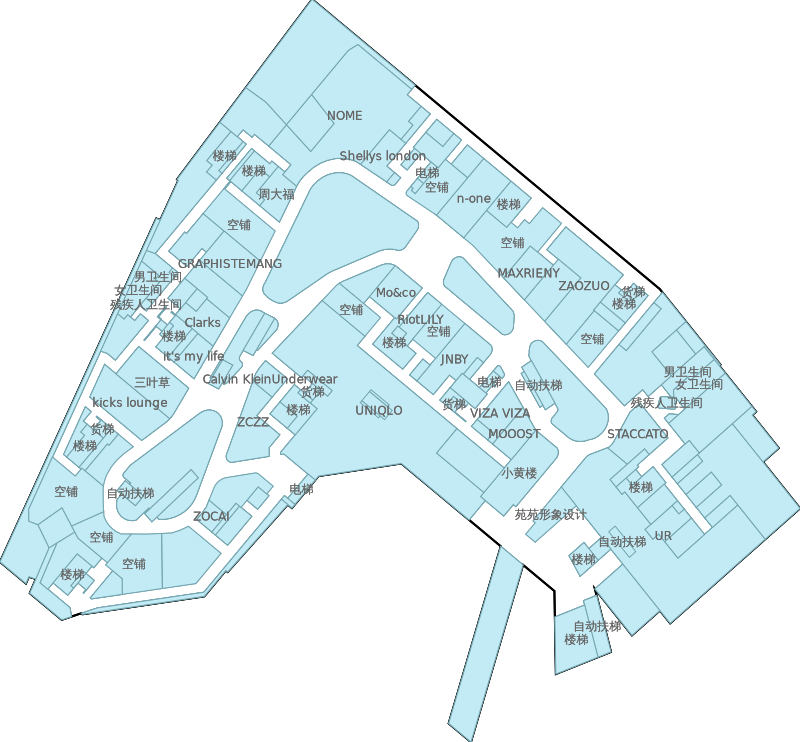

In [96]:
# Finally, let's plot
fig = visualize_trajectory(
                     trajectory_waypoint = trajectory_waypoint,
                     trajectory_timestamp = trajectory_text,
                     wifi_waypoint = wifi_waypoint,
                     wifi_timestamp = wifi_text,
                     sensor_waypoint = sensor_waypoint,
                     sensor_timestamp = sensor_text,
                     floor_plan_filename = floor_plan_filename,
                     width_meter = width_meter,
                     height_meter = height_meter,
                     title = title,
                     show=True
                     )

In [97]:
# HTML化
plotly.offline.plot(fig, filename='graph.html')  # ファイル名

'graph.html'

## 線形補完によりwifiのwaypointを取得
非線形も含まれるだろうがここでは全て線形補完とする

線形補完の問題点としてそのまま補完をしようとするとxが小さい値から大きい値を進行方向とみなし補完してしまう。  
これは意図するところではないので各step単位で補完する必要がある。ちょっと面倒なので一旦スルー。

In [56]:
# # https://qiita.com/maskot1977/items/913ef108ff1e2ba5b63f
# # 補完関数一覧を可視化。
# x_latent = np.linspace(min(x_observed), max(x_observed), 100)
# ip1 = ["最近傍点補間", lambda x, y: interpolate.interp1d(x, y, kind="nearest")]
# ip2 = ["線形補間", interpolate.interp1d]
# ip3 = ["ラグランジュ補間", interpolate.lagrange]
# ip4 = ["重心補間", interpolate.BarycentricInterpolator]
# ip5 = ["Krogh補間", interpolate.KroghInterpolator]
# ip6 = ["2次スプライン補間", lambda x, y: interpolate.interp1d(x, y, kind="quadratic")]
# ip7 = ["3次スプライン補間", lambda x, y: interpolate.interp1d(x, y, kind="cubic")]
# ip8 = ["秋間補間", interpolate.Akima1DInterpolator]
# ip9 = ["区分的 3 次エルミート補間", interpolate.PchipInterpolator]

# for method_name, method in [ip1, ip2, ip3, ip4, ip5, ip6, ip7, ip8, ip9]:
#     print(method_name)
#     fitted_curve = method(x_observed, y_observed)
#     plt.scatter(x_observed, y_observed, label="observed")
#     plt.plot(x_latent, fitted_curve(x_latent), c="red", label="fitted")
#     plt.grid()
#     plt.legend()
#     plt.show()

可視化してみた感じだと以下の方法が良さげ。この中から壁をうまく避けれそうなものを選びたい。
- 最近傍点補完
- 線形補完
- 秋間補間
- 区分的3次エルミート補間

In [24]:
# @noglobal
# def complement_wifi_waypoint_by_linear(
#         trajectory_timestamp, wifi_timestamp, sensor_timestamp, sensor_waypoint, 
#         x_observed, y_observed, linear_func, delta_time=500  # ms  timestampをこの単位で分割
#         ):    

#     # trajectoryの間に細かい点をdelta_time刻みで作成
#     n_split = int((max(trajectory_timestamp) - min(trajectory_timestamp)) / delta_time)  # delta_time刻みとなるように分割数を指定
#     timestamp_latent = np.linspace(min(trajectory_timestamp), max(trajectory_timestamp), n_split).astype(int)
#     x_latent = np.linspace(min(x_observed), max(x_observed), n_split)
#     y_latent = np.linspace(min(y_observed), max(y_observed), n_split)

#     # 線形補完関数の適用
#     for method_name, method in [linear_func]:
#         print(method_name)
#         fitted_curve = method(x_observed, y_observed)

#     # wifiのtimestampに最も近いものをsplit_timestampから取得しそれに対応するwaypointをwifiのwaypointとして取得
#     wifi_x = []
#     wifi_y = []
#     wifi_nearest_timestamp = []
#     for i in wifi_timestamp:
#         idx = np.abs(timestamp_latent - i).argmin()  # wifiデータとtimestampが最も近いものをlatentから取得
#         # wifi_nearest_timestamp.append(split_timestamp[idx])
#         wifi_x.append(x_latent[idx])
#         wifi_y.append(fitted_curve(x_latent)[idx])
#     wifi_waypoint = np.stack([wifi_x, wifi_y], axis=1)
#     return wifi_waypoint

In [57]:
# wifi_waypoint_by_linear = complement_wifi_waypoint_by_linear(
#         trajectory_timestamp, wifi_timestamp, sensor_timestamp, sensor_waypoint, 
#         x_observed, y_observed, linear_func=ip1, delta_time=500)

In [58]:
# x_wifi = wifi_waypoint_by_linear[:,0]
# y_wifi = wifi_waypoint_by_linear[:,1]
# plt.scatter(x_wifi, y_wifi, label="wifi")  # waypoint
# plt.scatter(x_observed, y_observed, label="waypoint")  # waypoint
# plt.plot(x_latent, fitted_curve(x_latent), c="red", label="fitted")
# plt.legend()